# Hackathon – Jour 2 : Exploration de données

Ce notebook présente l'analyse exploratoire des données bruit et trafic aérien pour la région Île-de-France.

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
# Affichage plus lisible
pd.set_option("display.max_columns", None)


## 1. Chargement des données

In [4]:

bruit = pd.read_csv("../Data/bruit_survol.csv")
opensky = pd.read_csv("../Data/opensky_snapshot.csv")
flights = pd.read_csv("../Data/flights_history.csv")

print("Bruit:", bruit.shape)
print("OpenSky:", opensky.shape)
print("Flights:", flights.shape)


Bruit: (146, 8)
OpenSky: (100, 11)
Flights: (150, 9)


## 2. Nettoyage des données

In [5]:

# Conversion des dates
bruit["timestamp_iso"] = pd.to_datetime(bruit["timestamp_iso"])
opensky["time_position_unix"] = pd.to_datetime(opensky["time_position_unix"], unit="s")
flights["first_seen_iso"] = pd.to_datetime(flights["first_seen_iso"])
flights["last_seen_iso"] = pd.to_datetime(flights["last_seen_iso"])

# Suppression doublons
bruit = bruit.drop_duplicates()
opensky = opensky.drop_duplicates()
flights = flights.drop_duplicates()

# Aperçu
bruit.head()


,station_id,station_name,timestamp_iso,LAeq_dB,Lmax_dB,latitude,longitude,airport
0,SURV006,Le Bourget - Station 2,2025-09-22 08:12:00,58.0,63.6,48.925908,2.476151,CDG
1,SURV006,Le Bourget - Station 2,2025-09-22 02:37:00,53.6,58.9,48.963169,2.438372,ORY
2,SURV002,Aéroport Charles de Gaulle - Sud,2025-09-22 07:15:00,52.2,59.8,48.881463,2.376714,CDG
3,SURV006,Le Bourget - Station 2,2025-09-21 17:24:00,56.5,56.8,48.831003,2.371886,CDG
4,SURV005,Le Bourget - Station 1,2025-09-21 21:36:00,53.9,60.8,48.863679,2.329385,CDG


## 3. Analyse exploratoire des données

In [6]:
print("Statistiques bruit:")
cols_bruit = [col for col in bruit.columns if bruit[col].dtype in ['float64', 'int64']]
if cols_bruit:
    print(bruit[cols_bruit].describe())
else:
    print("Aucune colonne numérique trouvée dans bruit.")

print("\nStatistiques vols:")
cols_opensky = [col for col in opensky.columns if opensky[col].dtype in ['float64', 'int64']]
if cols_opensky:
    print(opensky[cols_opensky].describe())
else:
    print("Aucune colonne numérique trouvée dans opensky.")


Statistiques bruit:
          LAeq_dB     Lmax_dB    latitude   longitude
count  146.000000  146.000000  146.000000  146.000000
mean    55.701370   61.773973   48.894695    2.403992
std      4.070736    5.210322    0.038643    0.052755
min     46.100000   49.900000   48.795210    2.300622
25%     52.600000   58.000000   48.863759    2.360000
50%     55.750000   61.500000   48.899500    2.409537
75%     58.400000   65.650000   48.918198    2.442955
max     67.000000   74.400000   48.976000    2.538000

Statistiques vols:
        longitude    latitude  baro_altitude_m  velocity_m_s  heading_deg  \
count  100.000000  100.000000       100.000000    100.000000   100.000000   
mean     2.363117   48.870806      8888.950000    211.025000   195.047000   
std      0.085019    0.062658      4275.743284     59.932232   110.530148   
min      2.187034   48.764192         0.000000     88.000000    18.600000   
25%      2.315384   48.822182      6133.500000    173.425000   101.725000   
50%      2.3

## 4. Visualisations

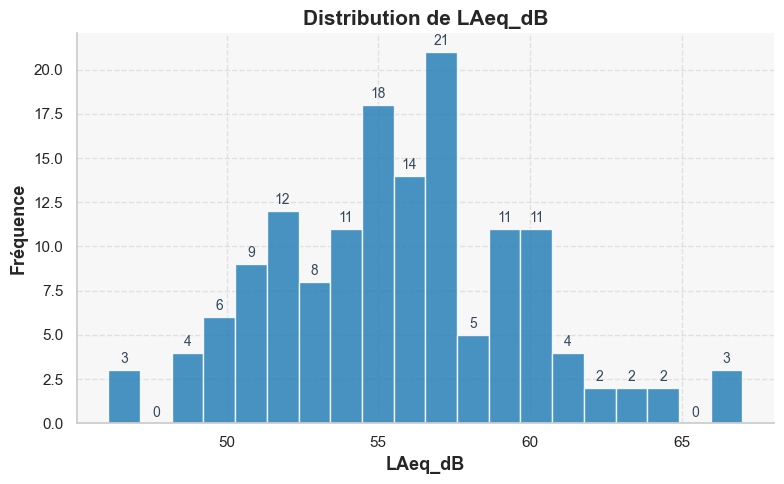

In [ ]:

num_cols_bruit = [col for col in bruit.columns if bruit[col].dtype in ['float64', 'int64']]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,5))
n, bins, patches = ax.hist(
    bruit[num_cols_bruit[0]],
    bins=20,
    color="#2980b9",
    alpha=0.85,
    edgecolor="white"
)
ax.set_xlabel(num_cols_bruit[0], fontsize=13, fontweight="bold")
ax.set_ylabel("Fréquence", fontsize=13, fontweight="bold")
ax.set_title(f"Distribution de {num_cols_bruit[0]}", fontsize=15, fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.5)
ax.set_facecolor("#f7f7f7")
sns.despine(ax=ax)

for i in range(len(n)):
    ax.text(
        (bins[i] + bins[i+1]) / 2,
        n[i] + max(n)*0.01,
        f"{int(n[i])}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="#34495e"
    )

plt.tight_layout()
plt.show()

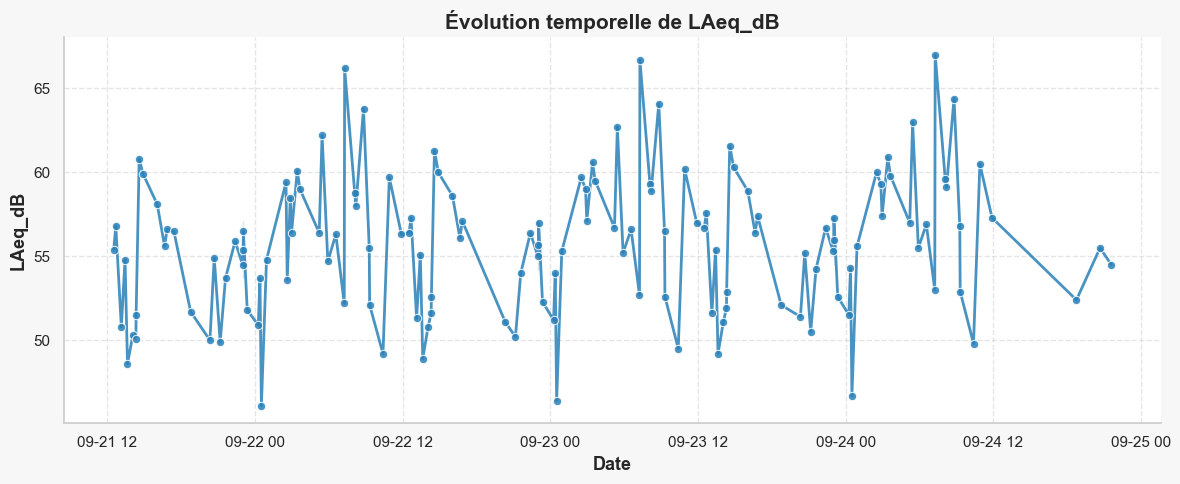

In [ ]:

if "timestamp_iso" in bruit.columns and num_cols_bruit:
    df_plot = bruit.dropna(subset=["timestamp_iso", num_cols_bruit[0]]).sort_values("timestamp_iso")
    if not df_plot.empty:
        plt.figure(figsize=(12, 5))
        sns.lineplot(
            data=df_plot,
            x="timestamp_iso",
            y=num_cols_bruit[0],
            marker="o",
            color="#2980b9",
            linewidth=2,
            alpha=0.85
        )
        plt.ylabel(num_cols_bruit[0], fontsize=13, fontweight="bold")
        plt.xlabel("Date", fontsize=13, fontweight="bold")
        plt.title(f"Évolution temporelle de {num_cols_bruit[0]}", fontsize=15, fontweight="bold")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.gcf().set_facecolor("#f7f7f7")
        sns.despine()
        plt.tight_layout()
        plt.show()
    else:
        print("Aucune donnée valide pour la série temporelle.")
else:
    print("Impossible d'afficher la série temporelle : colonne timestamp_iso ou numérique manquante.")

In [ ]:

num_cols_bruit = [col for col in bruit.columns if bruit[col].dtype in ['float64', 'int64']]
val_col = num_cols_bruit[0] if num_cols_bruit else None
lat_col = next((col for col in bruit.columns if 'lat' in col.lower()), None)
lon_col = next((col for col in bruit.columns if 'lon' in col.lower()), None)

from branca.colormap import linear

if lat_col and lon_col and val_col and val_col in bruit.columns:

    m = folium.Map(
        location=[bruit[lat_col].mean(), bruit[lon_col].mean()],
        zoom_start=10,
        tiles="OpenStreetMap"
    )

    colormap = linear.YlOrRd_09.scale(bruit[val_col].min(), bruit[val_col].max())
    colormap.caption = f"Niveau de bruit ({val_col})"

    for _, row in bruit.dropna(subset=[lat_col, lon_col, val_col]).iterrows():
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=7,
            color=colormap(row[val_col]),
            fill=True,
            fill_color=colormap(row[val_col]),
            fill_opacity=0.7,
            popup=folium.Popup(
                f"<b>Station:</b> {row.get('station_name', '')}<br>"
                f"<b>{val_col}:</b> {row[val_col]:.2f} dB<br>"
                f"<b>Date:</b> {row.get('timestamp_iso', '')}",
                max_width=250
            ),
        ).add_to(m)

    colormap.add_to(m)

    from IPython.display import display
    display(m)
else:
    print("Colonnes latitude/longitude ou valeur de bruit manquantes ou incorrectes pour la carte.")

## 5. Analyses complémentaires

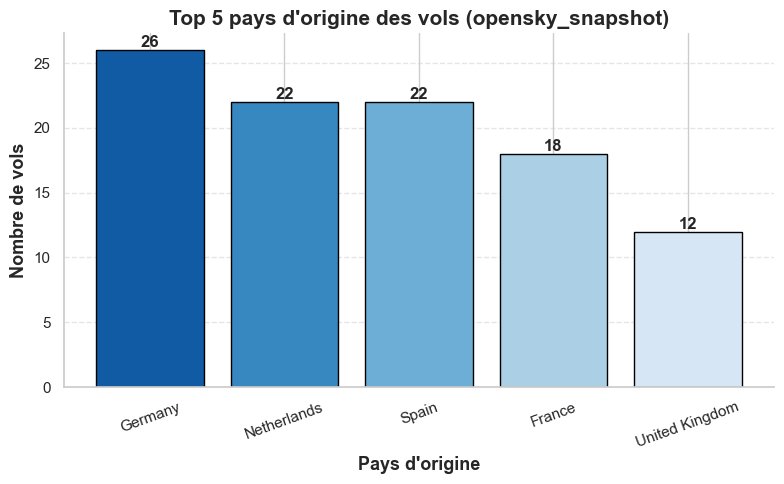

In [ ]:

if "origin_country" in opensky.columns:
    top_origins = opensky["origin_country"].value_counts().head(5)
    plt.figure(figsize=(8, 5))

    colors = sns.color_palette("Blues_r", n_colors=len(top_origins))
    bars = plt.bar(top_origins.index, top_origins.values, color=colors, edgecolor="black")
    plt.title("Top 5 pays d'origine des vols (opensky_snapshot)", fontsize=15, fontweight="bold")
    plt.ylabel("Nombre de vols", fontsize=13, fontweight="bold")
    plt.xlabel("Pays d'origine", fontsize=13, fontweight="bold")
    plt.xticks(rotation=20)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    sns.despine()

    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()), 
                 ha='center', va='bottom', fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()
else:
    print("Colonne 'origin_country' non trouvée dans opensky_snapshot.")